In [ ]:
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def map_boundaries(A, mn, mx, a, b, inverse=False):
    # Define a lambda function for calculating points
    mn = mn.view(-1, 1)
    mx = mx.view(-1, 1)

    calc_pt = lambda x: mn + (mx - mn) * x / 3

    # Calculate points
    if inverse:
        fst1, snd1 = calc_pt(1), calc_pt(2)
        fst2, snd2 = calc_pt(a), calc_pt(b)
    else:
        fst1, snd1 = calc_pt(a), calc_pt(b)
        fst2, snd2 = calc_pt(1), calc_pt(2)
        
    mask1 = (A >= mn) & (A < fst1)
    mask2 = (A >= fst1) & (A < snd1)
    mask3 = (A >= snd1) & (A <= mx)
    # Apply piecewise linear transformations
    A = torch.where(mask1, (A - mn) / (fst1 - mn) * (fst2 - mn) + mn, A)
    A = torch.where(mask2, (A - fst1) / (snd1 - fst1) * (snd2 - fst2) + fst2, A)
    A = torch.where(mask3, (A - snd1) / (mx - snd1) * (mx - snd2) + snd2, A)

    return A

In [ ]:
def expand_middle(A, amount=0.03):
    assert(amount < 0.5)

    mn, _ = torch.min(A, dim=0, keepdims=True)
    mx, _ = torch.max(A, dim=0, keepdims=True)

    fst = mn + (mx - mn) * (1 + amount) / 3
    snd = mn + (mx - mn) * (2 - amount) / 3

    targ_fst = mn + (mx - mn) * 1 / 3
    targ_snd = mn + (mx - mn) * 2 / 3
    
    mask1 = (A >= mn) & (A < fst)
    mask2 = (A >= fst) & (A < snd)
    mask3 = (A >= snd) & (A <= mx)

    A = torch.where((A >= mn) & (A < fst), (A - mn) / (fst - mn) * (targ_fst - mn) + mn, A)
    A = torch.where((A >= fst) & (A < snd), (A - fst) / (snd - fst) * (targ_snd - targ_fst) + targ_fst, A)
    A = torch.where((A >= snd) & (A <= mx), (A - snd) / (mx - snd) * (mx - targ_snd) + targ_snd, A)

    return A


In [ ]:
samples = torch.arange(0, 3000).view(1, -1).tile((2, 1))

In [ ]:
samples.shape

torch.Size([2, 3000])

In [ ]:
mn = torch.min(samples, dim=1, keepdim=True)[0]
mx = torch.max(samples, dim=1, keepdim=True)[0]

In [ ]:
print(mn.shape)
print(mx.shape)

torch.Size([2, 1])
torch.Size([2, 1])


In [ ]:
samples_transformed = map_boundaries(samples, mn, mx, 0.8, 2.2);

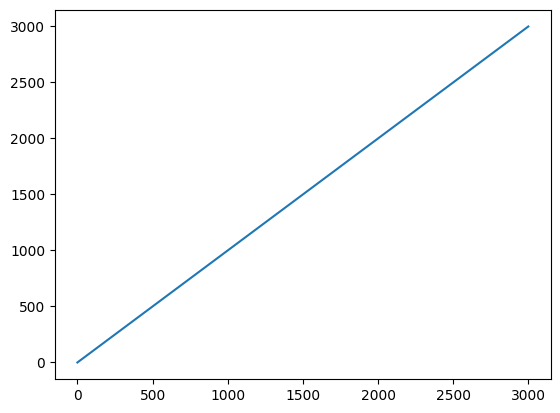

In [ ]:
plt.plot(samples[0])

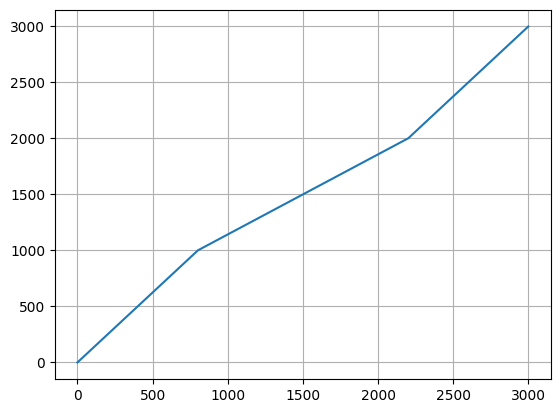

In [ ]:
plt.grid()
plt.plot(samples_transformed[1])

In [ ]:
def transform_boundaries(x1, y1, vals):
    x1 /= 3
    y1 /= 3
    
    x2 = 1 - x1
    y2 = 1 - y1

    def custom_htanh(vals, x1, y1, x2, y2):
        m = torch.nn.Hardtanh(x1, x2)
        tanh_res = m(vals) 
        return (tanh_res - x1)/(1 - 2*x1) * (y2 - y1)
        
    sub_y = (y1/x1)*(x2-x1)
    fast_transform = custom_htanh(vals, x1, y1, x2, y2-sub_y) + vals * (y1/x1)
    return fast_transform

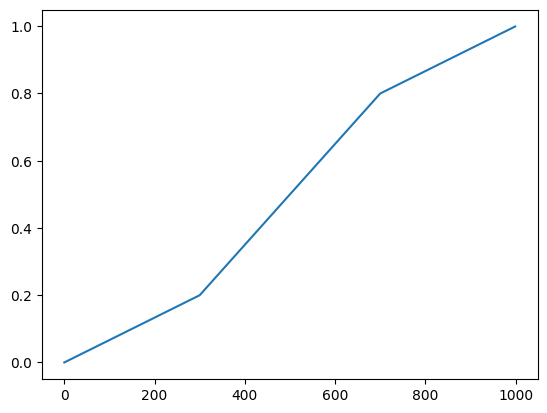

In [ ]:
plt.plot(transform_boundaries(0.9, 0.6, torch.arange(1000)/1000))

In [ ]:
samples_orig = torch.randn(10**5)
samples = (samples_orig + samples_orig.min()) / (samples_orig.max() - samples_orig.min())

In [ ]:
samples_transformed = transform_boundaries(0.8/3, 1/3, samples)

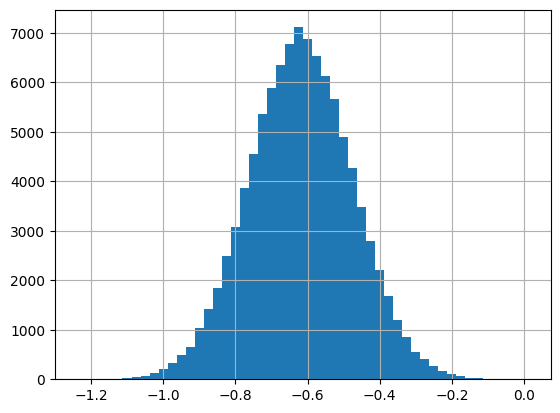

In [ ]:
plt.grid()
plt.hist(samples_transformed, bins=50);

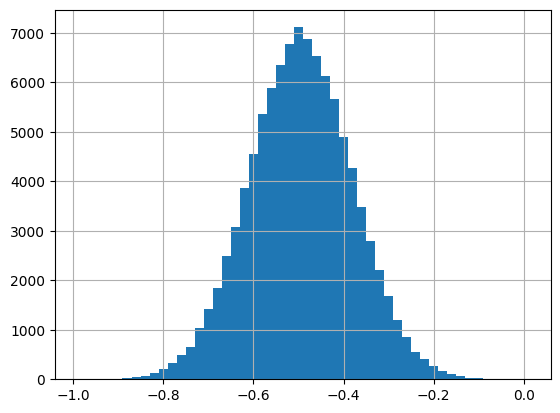

In [ ]:
plt.grid()
plt.hist(samples, bins=50);

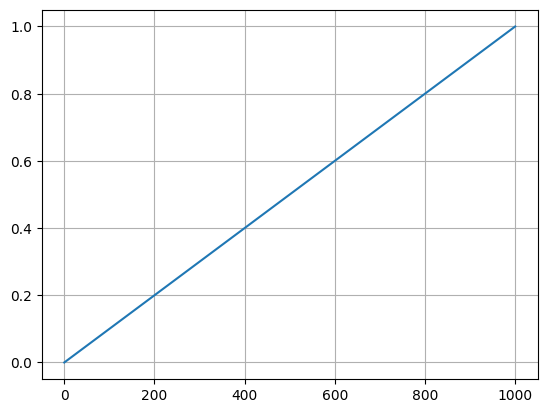

In [ ]:
inverse_transformed = transform_boundaries(0.35, 0.25, samples_transformed)

plt.grid()
plt.plot(inverse_transformed)

##QQ-plots

In [ ]:
import numpy as np
import scipy.stats as stats

n_runs = 10
sample_size = 100

# Generate the data
real_distributions = np.random.uniform(size=(n_runs, sample_size))

In [ ]:
# Calculate the means and standard deviations for each run
means = np.mean(real_distributions, axis=1, keepdims=True)
stds = np.std(real_distributions, axis=1, keepdims=True)

# Compute the average mean and standard deviation across the runs
#loc = np.mean(means)
#scale = np.mean(stds)

real_distributions = (real_distributions - means) / stds

In [ ]:
theoretical_quantiles = []
observed_quantiles = []
observed_std = []

for i in range(n_runs):
    qq_data = stats.probplot(real_distributions[i], dist=stats.norm(), fit=False)
    
    if i == 0:
        theoretical_quantiles = qq_data[0]
    
    observed_quantiles.append(qq_data[1])

observed_quantiles = np.array(observed_quantiles)
observed_mean = np.mean(observed_quantiles, axis=0)
observed_std = np.std(observed_quantiles, axis=0)

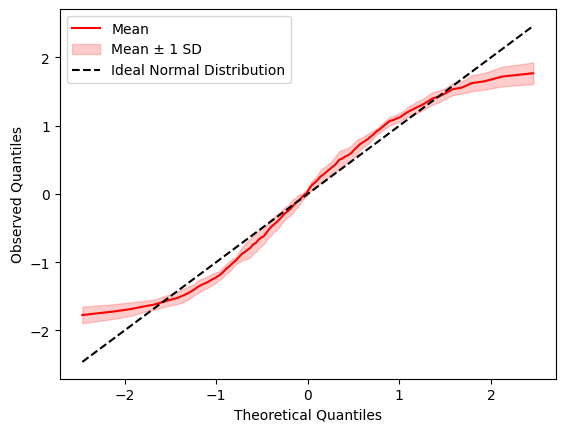

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Plot the mean line
ax.plot(theoretical_quantiles, observed_mean, color='red', label='Mean')

# Add shaded error bars (mean ± 1 SD)
ax.fill_between(theoretical_quantiles, observed_mean - observed_std, observed_mean + observed_std, color='red', alpha=0.2, label='Mean ± 1 SD')

# Plot the 45-degree line for an ideal normal distribution
ax.plot(theoretical_quantiles, theoretical_quantiles, 'k--', label=f'Ideal Normal Distribution')

ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Observed Quantiles')

ax.legend()
plt.show()


## Distribution of activations

In [ ]:
# arxiv:
#   2-bit order 1385, 1734, 4980, 9491, 3497, 1456, 6136, 4584, 2614, 9947, 6527, 5888, 8375, 1278, 2561
#   act_fp order 9322, 4530, 7196, 3231, 8458, 8907, 7794, 7942, 6806, 6743, 5184, 6655, 7649, 9929, 2841

# reddit:
#   2-bit order 3299, 2192, 9848, 2330, 7878, 6625, 6070, 2829, 4420, 9820
#   act_fp order 6895, 8699, 6773, 1039, 9948, 2142, 6308, 6075, 1995, 4197

# flickr:
#   2-bit order 5513, 8957, 7822, 4273, 4809, 5276, 1457, 9890, 5003, 3966, 5438, 9337, 8482, 7258, 2532, 4844, 4129, 3748, 5480, 7340
#   act_fp order 9663, 9082, 5515, 2515, 8182, 7295, 1804, 9517, 9416, 4236, 7805, 1771, 9641, 4539, 1482, 8423, 3625, 4100, 2497, 5048

In [ ]:
#col_sizes=(256 0)
#perc_values=(0.0001 0)

In [ ]:
import datetime

file_data = []

with open('/content/drive/MyDrive/Masters Thesis/exact_acts/blockwise_experiments/block_act_order.txt', 'r') as f:
    for line in f.readlines():
        # Split the line into parts
        parts = line.split()
        if parts[-1][-3:] != '.pt':
            continue

        # Extract the filename, filesize, and date & time
        filename = parts[8]
        filesize = parts[4]
        time_str = parts[7]
        
        
        # Add the data as a tuple to the list
        file_data.append((filename, filesize, time_str))

file_data = list(reversed(file_data))
print(file_data)

[('tensor_988410.pt', '11M', '15:14'), ('tensor_192114.pt', '11M', '15:14'), ('tensor_775075.pt', '83M', '15:14'), ('tensor_938939.pt', '11M', '15:14'), ('tensor_456804.pt', '11M', '15:14'), ('tensor_776398.pt', '83M', '15:14'), ('tensor_767902.pt', '11M', '15:14'), ('tensor_907886.pt', '11M', '15:14'), ('tensor_107487.pt', '11M', '15:15'), ('tensor_424032.pt', '11M', '15:15'), ('tensor_109767.pt', '83M', '15:15'), ('tensor_164552.pt', '11M', '15:15'), ('tensor_880584.pt', '11M', '15:15'), ('tensor_862405.pt', '83M', '15:15'), ('tensor_427822.pt', '11M', '15:15'), ('tensor_538012.pt', '11M', '15:15'), ('tensor_480358.pt', '11M', '15:17'), ('tensor_127687.pt', '11M', '15:17'), ('tensor_644081.pt', '83M', '15:17'), ('tensor_283808.pt', '11M', '15:17'), ('tensor_906271.pt', '11M', '15:17'), ('tensor_502021.pt', '83M', '15:17'), ('tensor_836038.pt', '11M', '15:17'), ('tensor_897112.pt', '11M', '15:17'), ('tensor_413959.pt', '11M', '15:18'), ('tensor_525765.pt', '11M', '15:18'), ('tensor_56

In [ ]:
def plot_data_dist(order, path, num_layers, title_pre, bit_name, dataset_name, collect_layers=True):
    all_acts = [[] for _ in range(num_layers)]

    layer_idx = 0
    for suf in order:
        if layer_idx >= num_layers and collect_layers == False:
            break

        all_acts[layer_idx].append(torch.load(f'{path}/tensor_{suf}.pt'))
        layer_idx = (layer_idx + 1) % num_layers

    if collect_layers:
        for i in range(len(all_acts)):
            all_acts[i] = torch.stack(all_acts[i], 0) 


    for i in range(num_layers):
        plt.title(title_pre + str(i))


        data = all_acts[i].view(-1).cpu().numpy()
        plt.hist(data * 3, bins=50)

        # Move data to GPU and calculate percentiles using PyTorch
        data_gpu = (all_acts[i] * 3).view(-1)
        percentile_33 = torch.kthvalue(data_gpu, int(1/3 * data_gpu.size(0))).values.item()
        percentile_67 = torch.kthvalue(data_gpu, int(2/3 * data_gpu.size(0))).values.item()

        # Draw red vertical lines at the 33rd and 67th percentiles
        plt.axvline(x=percentile_33, color='r', linestyle='--', label='33rd percentile')
        plt.axvline(x=percentile_67, color='r', linestyle='--', label='67th percentile')

        # Draw red vertical lines at the 33rd and 67th percentiles
        plt.axvline(x=1, color='b', linestyle='--', label='1')
        plt.axvline(x=2, color='b', linestyle='--', label='2')
        
        plt.xlabel('transformed activation value')
        plt.ylabel('# occurences')

        plt.legend()

        value1 = (percentile_33 - 1)
        value2 = (2 - percentile_67)

        # Add a yellow, transparent box containing the two values
        plt.text(0.95, 0.05, f"val1: {value1:6.3f}\nval2: {value2:6.3f}", fontsize=12,
                horizontalalignment='right', verticalalignment='bottom',
                transform=plt.gca().transAxes,
                bbox=dict(facecolor='wheat', alpha=0.8))

        plt.tight_layout()
        plt.savefig(f'{dataset_name}_{bit_name}_layer{i}.pdf', format='pdf')
        plt.clf()
        #plt.show()

In [ ]:
filenames, sizes, timestamps = zip(*file_data)

In [ ]:
all_acts = [None] * 8
path = "/content/drive/MyDrive/Masters Thesis/exact_acts/blockwise_experiments/arxiv_tensors_act"

for i in tqdm(range(10)):
    for j in range(8):
        suf = filenames[i * 8 + j]

        if all_acts[j] is None:
            all_acts[j] = torch.load(f'{path}/{suf}')
        else:
            all_acts[j] += torch.load(f'{path}/{suf}')

In [ ]:
orders = [[1385, 1734, 4980, 9491, 3497, 1456, 6136, 4584, 2614, 9947, 6527, 5888, 8375, 1278, 2561],
          [9322, 4530, 7196, 3231, 8458, 8907, 7794, 7942, 6806, 6743, 5184, 6655, 7649, 9929, 2841],
          [3299, 2192, 9848, 2330, 7878, 6625, 6070, 2829, 4420, 9820],
          [6895, 8699, 6773, 1039, 9948, 2142, 6308, 6075, 1995, 4197],
          [5513, 8957, 7822, 4273, 4809, 5276, 1457, 9890, 5003, 3966, 5438, 9337, 8482, 7258, 2532, 4844, 4129, 3748, 5480, 7340],
          [9663, 9082, 5515, 2515, 8182, 7295, 1804, 9517, 9416, 4236, 7805, 1771, 9641, 4539, 1482, 8423, 3625, 4100, 2497, 5038]]


datasets = ["arxiv", "reddit", "flickr"]
bit_sizes = ["2bit", "32bit"]

paths = ["/content/drive/MyDrive/Masters Thesis/exact_acts/2-bit_arxiv",
         "/content/drive/MyDrive/Masters Thesis/exact_acts/act_fp_arxiv",
         "/content/drive/MyDrive/Masters Thesis/exact_acts/2-bit_reddit/reddit_tensors",
         "/content/drive/MyDrive/Masters Thesis/exact_acts/act_fp_reddit/reddit_tensors_act",
         "/content/drive/MyDrive/Masters Thesis/exact_acts/2-bit_flickr/flickr_tensors",
         "/content/drive/MyDrive/Masters Thesis/exact_acts/act_fp_flickr/flickr_tensors"]

num_layers_lst = [3, 3, 2, 2, 2, 2]

In [ ]:
count_idx = 0

for dataset in datasets:
    for bit_size in bit_sizes:
        plot_data_dist(orders[count_idx], paths[count_idx], num_layers_lst[count_idx],
                       f"{dataset} activations, {bit_size}, layer: ", bit_size, dataset)        

        count_idx += 1

print(count_idx)

6


<Figure size 640x480 with 0 Axes>

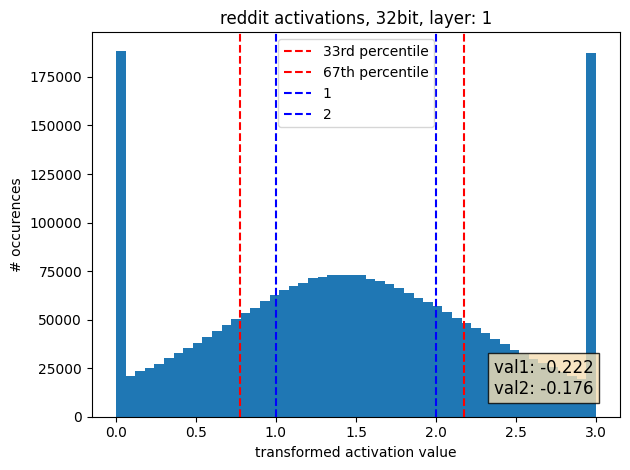

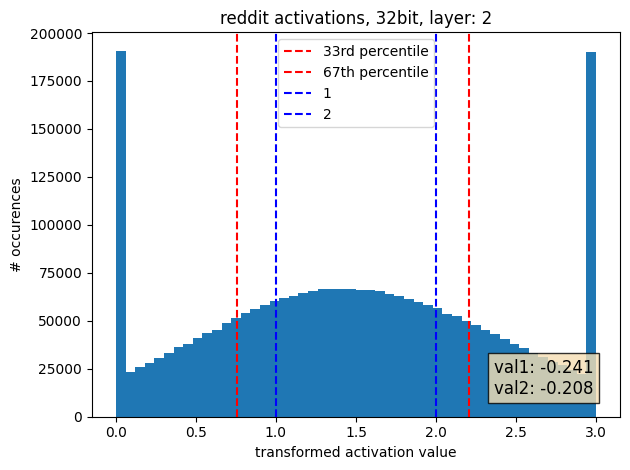

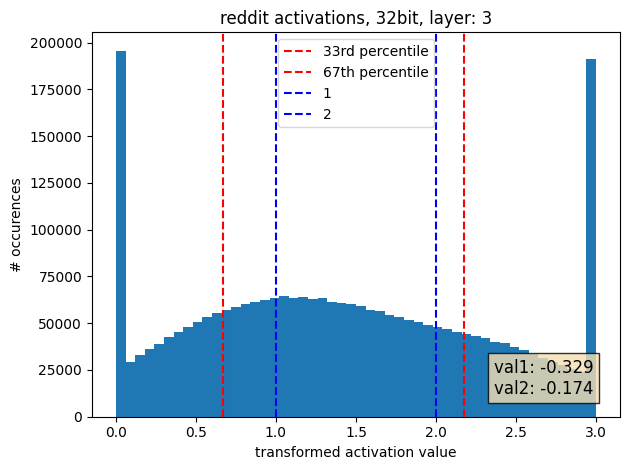

In [ ]:
#plot_data_dist([1385, 1734, 4980, 9491, 3497, 1456, 6136, 4584, 2614, 9947, 6527, 5888, 8375, 1278, 2561],
#               "/content/drive/MyDrive/Masters Thesis/exact_acts/2-bit_arxiv", 3, "reddit activations, 32bit, layer: ")

In [ ]:
all_acts[1].shape

torch.Size([232965, 76])

##Unbiased test

In [ ]:
def stochastic_round(x):
    x_floor = torch.floor(x)
    x_ceil = torch.ceil(x)
    x_fractional = x - x_floor
    
    # Create a random tensor with the same shape as x
    random_tensor = torch.rand_like(x)
    
    # Determine whether to round up or down based on the random tensor and the fractional part of x
    round_decision = random_tensor < x_fractional
    
    # Apply the rounding decision
    rounded_x = torch.where(round_decision, x_ceil, x_floor)
    
    return rounded_x

In [ ]:
def quant(x, B=3):
    Z, _ = torch.min(x, dim=1, keepdim=True)
    r = torch.max(x, dim=1, keepdim=True)[0] - Z
    return stochastic_round((x - Z) / r * B), r, Z

def dequant(x_quant, r, Z, B=3):
    return r * x_quant / B + Z

In [ ]:
before = torch.randn(1000, 128) + 2 - torch.linspace(-1, 1.5, 128).unsqueeze(0)

In [ ]:
avg_before = []
avg_f_before = []
avg_deq_before = []

x_quant, r, Z = quant(before)


iters = 5 * 10**2
for i in range(iters):
    if i % 1000 == 0:
        print(i)
    avg_before.append(before)
    avg_f_before.append(shrink_middle(dequant(expand_middle(x_quant), r, Z)))
    avg_deq_before.append(dequant(x_quant, r, Z))

avg_before = torch.dstack(avg_before)
avg_f_before = torch.dstack(avg_f_before)
avg_deq_before = torch.dstack(avg_deq_before)

print(torch.mean((avg_before - avg_f_before)**2))
print(torch.mean((avg_before - avg_deq_before)**2))

print(before.mean(), dequant(x_quant, r, Z).mean())

0
tensor(0.6036)
tensor(0.7118)
tensor(1.7523) tensor(1.7554)


## Stuff

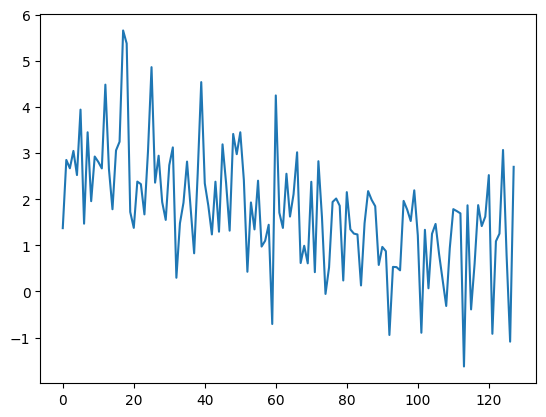

In [ ]:
plt.plot(before[0]);

'\nlabels = ["0b00", "0b01", "0b10", "0b11"]\nfor x, label in zip(x_coords, labels):\n    plt.text(x, y_coord, label, fontsize=14, ha=\'center\')\nplt.xlim(A.min()-0.4, A.max() + 1)\n'

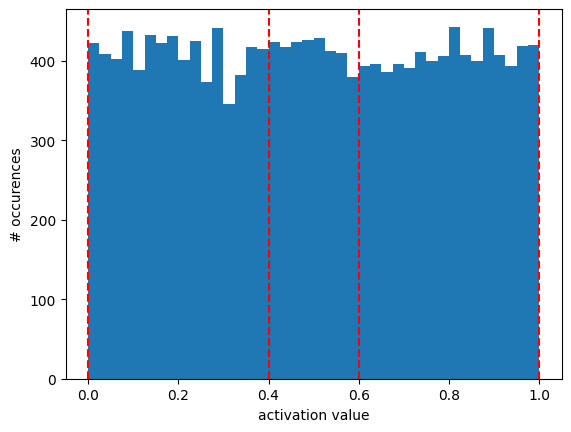

In [ ]:
plt.hist(A, bins=40, color='b')

#for q in torch.quantile(A, torch.arange(4)/3):
#    plt.axvline(q, color='r', linestyle='--')
amount = 0.2
fst = A.min() + (A.max() - A.min()) * (1 + amount) / 3
snd = A.min() + (A.max() - A.min()) * (2 - amount) / 3


plt.axvline(A.min(), color='r', linestyle='--')
plt.axvline(fst, color='r', linestyle='--')
plt.axvline(snd, color='r', linestyle='--')
plt.axvline(A.max(), color='r', linestyle='--')
plt.xlabel('activation value')
plt.ylabel('# occurences')

# Calculate x-coordinates for the text labels
x_coords = [
    A.min() + (A.max() - A.min()) * (2 * i + 0.4) / 6 for i in range(4)
]

# Choose a suitable y-coordinate for the text labels
y_coord = max(plt.hist(A, bins=40)[0]) * 0.93
# Add text labels

'''
labels = ["0b00", "0b01", "0b10", "0b11"]
for x, label in zip(x_coords, labels):
    plt.text(x, y_coord, label, fontsize=14, ha='center')
plt.xlim(A.min()-0.4, A.max() + 1)
'''


In [ ]:
def expand_middle(A, lo=0.4):
    hi = 3 - lo

    mn, _ = torch.min(A, dim=1, keepdims=True)
    mx, _ = torch.max(A, dim=1, keepdims=True)

    fst = mn + (mx - mn) * lo / 3
    snd = mn + (mx - mn) * hi / 3

    targ_fst = mn + (mx - mn) * 1 / 3
    targ_snd = mn + (mx - mn) * 2 / 3
    
    mask1 = (A >= mn) & (A < fst)
    mask2 = (A >= fst) & (A < snd)
    mask3 = (A >= snd) & (A <= mx)

    A = torch.where(mask1, (A - mn) / (fst - mn) * (targ_fst - mn) + mn, A)
    A = torch.where(mask2, (A - fst) / (snd - fst) * (targ_snd - targ_fst) + targ_fst, A)
    A = torch.where(mask3, (A - snd) / (mx - snd) * (mx - targ_snd) + targ_snd, A)

    return A, mn, mx


def shrink_middle(A, mn, mx, lo=0.4):
    hi = 3 - lo

    fst = mn + (mx - mn) * 1 / 3
    snd = mn + (mx - mn) * 2 / 3
    
    targ_fst = mn + (mx - mn) * lo / 3
    targ_snd = mn + (mx - mn) * hi / 3
    
    mask1 = (A >= mn) & (A < fst)
    mask2 = (A >= fst) & (A < snd)
    mask3 = (A >= snd) & (A <= mx)

    A = torch.where(mask1, (A - mn) / (fst - mn) * (targ_fst - mn) + mn, A)
    A = torch.where(mask2, (A - fst) / (snd - fst) * (targ_snd - targ_fst) + targ_fst, A)
    A = torch.where(mask3, (A - snd) / (mx - snd) * (mx - targ_snd) + targ_snd, A)

    return A

In [ ]:
A = torch.randn(100, 128)

In [ ]:
print(A)

tensor([[-8.7706e-01, -1.0363e+00, -4.9320e-01,  ...,  6.0239e-01,
         -1.6191e+00,  1.2095e+00],
        [ 1.7182e+00, -1.8363e+00,  9.0549e-01,  ..., -1.1473e+00,
         -2.8302e-01, -2.3621e-01],
        [-4.7768e-01, -1.7173e+00, -8.0077e-01,  ...,  2.3057e+00,
          6.6101e-01,  4.2050e-01],
        ...,
        [-2.0433e+00,  4.9288e-01,  4.1065e-02,  ..., -4.3535e-01,
          2.6630e+00, -1.2550e+00],
        [ 1.4830e+00,  2.2599e-01,  1.5082e+00,  ..., -4.0925e-05,
          1.4493e+00,  5.6573e-01],
        [-8.7808e-01, -3.6482e-01,  1.1404e+00,  ..., -1.0350e+00,
          6.6861e-01,  5.6680e-01]])


In [ ]:
print(expand_middle(A)[0])

tensor([[-0.3505, -0.4229, -0.1760,  ...,  0.3220, -0.8629,  0.5979],
        [ 1.4210, -1.0085,  0.2378,  ..., -0.6953, -0.3025, -0.2812],
        [-0.4600, -1.0235, -0.6069,  ...,  2.3057,  0.0576, -0.0518],
        ...,
        [-0.8611,  0.2917,  0.0863,  ..., -0.1303,  1.9657, -0.5028],
        [ 0.4629, -0.1085,  0.4744,  ..., -0.2112,  0.4476,  0.0460],
        [-0.4428, -0.2095,  0.4747,  ..., -0.5141,  0.2603,  0.2140]])


In [ ]:
print(shrink_middle(*expand_middle(A)))

tensor([[-8.7706e-01, -1.0363e+00, -4.9320e-01,  ...,  6.0239e-01,
         -1.6191e+00,  1.2095e+00],
        [ 1.7182e+00, -1.8363e+00,  9.0549e-01,  ..., -1.1473e+00,
         -2.8302e-01, -2.3621e-01],
        [-4.7768e-01, -1.7173e+00, -8.0077e-01,  ...,  2.3057e+00,
          6.6101e-01,  4.2050e-01],
        ...,
        [-2.0433e+00,  4.9288e-01,  4.1065e-02,  ..., -4.3535e-01,
          2.6630e+00, -1.2550e+00],
        [ 1.4830e+00,  2.2599e-01,  1.5082e+00,  ..., -4.1008e-05,
          1.4493e+00,  5.6573e-01],
        [-8.7808e-01, -3.6482e-01,  1.1404e+00,  ..., -1.0350e+00,
          6.6861e-01,  5.6680e-01]])


In [ ]:
print(expand_middle_2(A))

NameError: ignored

In [ ]:
def shrink_middle(A, amount=0):
    B = torch.clone(A)
    assert(amount < 0.5)

    mn = B.min()
    mx = B.max()

    fst = mn + (mx - mn) * 1 / 3
    snd = mn + (mx - mn) * 2 / 3

    targ_fst = mn + (mx - mn) * (1 + amount) / 3
    targ_snd = mn + (mx - mn) * (2 - amount) / 3
    
    mask1 = (B >= mn) & (B < fst)
    mask2 = (B >= fst) & (B < snd)
    mask3 = (B >= snd) & (B <= mx)
    
    B[mask1] = (B[mask1] - mn) / (fst - mn) * (targ_fst - mn) + mn
    B[mask2] = (B[mask2] - fst) / (snd - fst) * (targ_snd - targ_fst) + targ_fst
    B[mask3] = (B[mask3] - snd) / (mx - snd) * (mx - targ_snd) + targ_snd

    return B

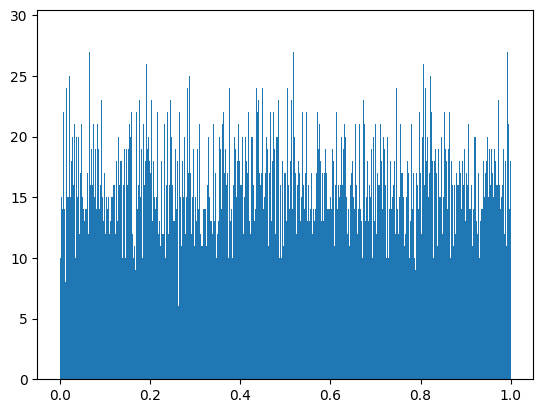

In [ ]:
plt.hist(A, bins=1000);

In [ ]:
# Function to compute B and update A in-place
def compute_B_and_update_A(A, batch_size=128):
    M = A.shape[0]
    B = torch.zeros(M, 4, device='cuda')

    for i in range(0, M, batch_size):
        A_batch = A[i:i+batch_size]

        # Sort A_batch along the last dimension (columns)
        sorted_A, indices = torch.sort(A_batch, dim=-1)

        # Reshape sorted_A to shape (M, 4, 32)
        reshaped_A = sorted_A.view(-1, 4, 32)

        # Compute the mean along the last dimension (size 32)
        B[i:i+batch_size] = torch.mean(reshaped_A, dim=-1)

        # Create A_quantized tensor with values [0, 1, 2, 3] based on the indices
        A_quantized = (torch.arange(128, dtype=torch.float, device='cuda') // 32).repeat(A_batch.shape[0], 1)

        # Scatter the values to the original positions using the indices
        A_quantized = A_quantized.scatter(1, indices, A_quantized)

        # Update A in-place
        A[i:i+batch_size] = A_quantized

    return B

B = compute_B_and_update_A(A, batch_size=100)
print(A)  # Updated A with 4 unique values in each row
print(B.shape)  # Output: torch.Size([M, 4])

tensor([[2., 2., 3.,  ..., 1., 1., 3.],
        [0., 3., 3.,  ..., 3., 3., 1.],
        [2., 2., 0.,  ..., 3., 1., 1.],
        ...,
        [3., 1., 2.,  ..., 3., 2., 2.],
        [0., 1., 1.,  ..., 0., 2., 3.],
        [1., 0., 0.,  ..., 0., 3., 1.]], device='cuda:0')
torch.Size([100000, 4])


In [ ]:
def compute_A_dequantized(B, A_updated, batch_size=256):
    M = A_updated.shape[0]
    num_batches = (M + batch_size - 1) // batch_size

    A_dequantized = torch.empty_like(A_updated)

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, M)

        A_dequantized_batch = B[start_idx:end_idx].gather(1, A_updated[start_idx:end_idx].long())
        A_dequantized[start_idx:end_idx] = A_dequantized_batch

    return A_dequantized

In [ ]:
A_new = compute_A_dequantized(B, A)

In [ ]:
import matplotlib.pyplot as plt

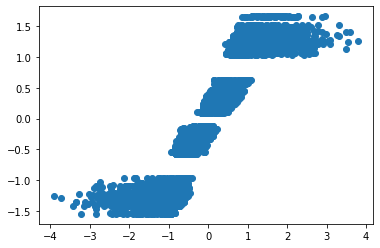

In [ ]:
plt.scatter(A_old[:64].detach().cpu().reshape(-1), A_new[:64].detach().cpu().reshape(-1))

In [ ]:
A_new.mean()

tensor(-0.0003, device='cuda:0')

In [ ]:
A_old.mean()

tensor(-0.0003, device='cuda:0')